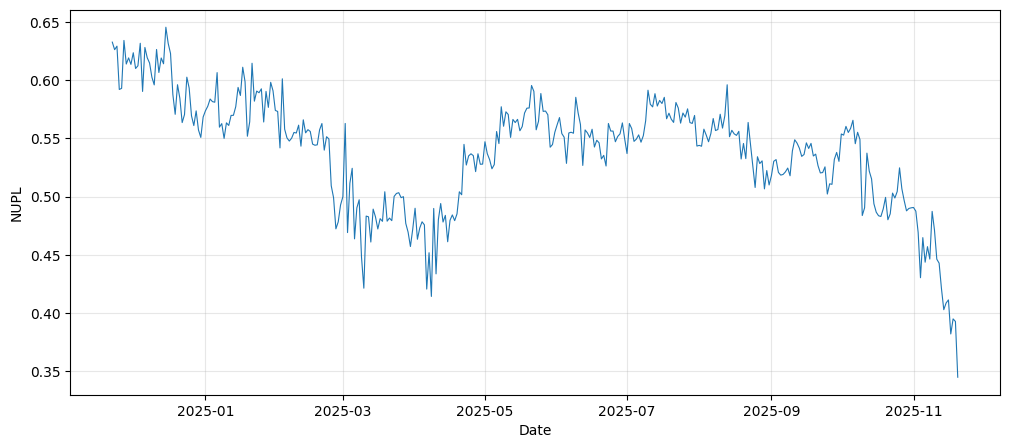

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from functions_peaks import PlotLine

df = pd.read_csv("./BitCoinLab/net_unrealized_profit_loss_2024-11-22---2025-11-21.csv")
df["date"] = pd.to_datetime(df["date"])
PlotLine(df, x_col="date", y_col="net_unrealized_profit_loss", ylabel="NUPL")

In [113]:
def sliding_window_analysis(signal, initial_window_size=5, stability_threshold=0.006):
    if initial_window_size % 2 == 0:
        raise ValueError("initial_window_size debe ser impar para centrar la ventana.")

    space = initial_window_size // 2
    window_ampliation = 0

    N = len(signal)
    spacial_means = np.full(N, np.nan)
    definitive_means = np.full(N, np.nan)
    spacial_stds = np.full(N, np.nan)
    definitive_stds = np.full(N, np.nan)

    for i in range(space, N - space):

        local_window = signal[i - space: i + space + 1]
        mean_window = np.mean(local_window)
        std_window = np.std(local_window)

        spacial_means[i] = mean_window
        spacial_stds[i] = std_window

        diff = abs(spacial_means[i - 1] - mean_window)
        if abs(spacial_means[i - 1] - mean_window) < stability_threshold:
            window_ampliation += 1
        else:
            start_segment = i - 1 - window_ampliation
            end_segment = i + space
            global_window = signal[start_segment: end_segment]
            global_mean = np.mean(global_window)
            global_std = np.std(global_window)
            window_ampliation = 0

            definitive_means[start_segment: end_segment] = global_mean
            definitive_stds[start_segment: end_segment] = global_std

    definitive_means[-1 - window_ampliation: -1] = spacial_means[-1 - window_ampliation: -1]
    definitive_stds[-1 - window_ampliation: -1] = spacial_stds[-1 - window_ampliation: -1]

    return spacial_means, spacial_stds, definitive_means, definitive_stds

In [114]:
def plot_segmented_mean(df, signal_col, means_array, title="Segmented Mean Plot", scatter=True):
    plt.figure(figsize=(14, 7))

    plt.plot(
        df.index,
        df[signal_col],
        label=f'Signal ({signal_col})',
        color='gray',
        alpha=0.6,
        linewidth=1
    )

    plt.plot(
        df.index,
        means_array,
        label='Corrected mean',
        color='red',
        linewidth=2.5
    )

    if scatter:
        valid_means = np.where(~np.isnan(means_array))[0]

        diff_means = np.abs(np.diff(means_array[valid_means]))
        jump_indices = valid_means[:-1][diff_means > 1e-6]
        plt.scatter(
            df.index[jump_indices],
            means_array[jump_indices],
            marker='o',
            color='blue',
            s=30,
            label='Change Points',
            zorder=5
        )

    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

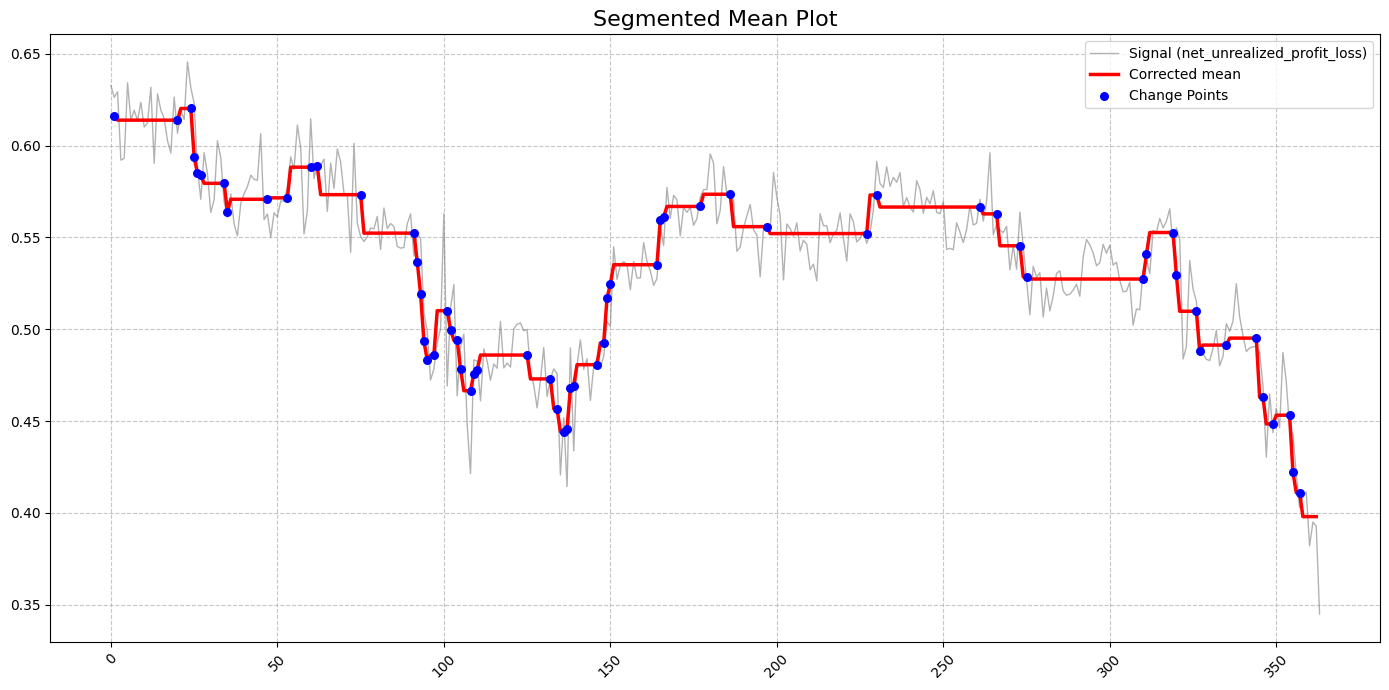

In [115]:
spacial_means_corrected, spacial_stds_corrected, def_mean, def_std = sliding_window_analysis(
    df_z["net_unrealized_profit_loss"],
    initial_window_size=5,
    stability_threshold=0.007
)

plot_segmented_mean(
    df=df_z,
    signal_col="net_unrealized_profit_loss",
    means_array=def_mean
)

In [116]:
def zigzag_algorithm(series, prop=0.03):
    if not (0 < prop < 1):
        raise ValueError("Proportion between 0 and 1")

    zigzag_series = pd.Series(np.nan, index=series.index, dtype=float)

    last_pivot_index = 0
    last_pivot_value = series.iloc[0]
    zigzag_series.iloc[0] = last_pivot_value

    # 1: Up, -1: Down, 0: Flat/Initial
    current_direction = 0

    for i in range(1, len(series)):
        current_price = series.iloc[i]

        if current_direction == 0:  # Initial state or after pivot
            # Comprobe if the price has moved more than threshold from the last pivot
            if current_price > last_pivot_value * (1 + prop):
                current_direction = 1  # Start of an upward trend
            elif current_price < last_pivot_value * (1 - prop):
                current_direction = -1  # Start of a bearish trend

        elif current_direction == 1:  # Upward trend
            # If the current price exceeds the value of the last pivot, update the pivot
            if current_price > last_pivot_value:
                last_pivot_value = current_price
                last_pivot_index = i
            # If the price has fallen sufficiently
            elif current_price < last_pivot_value * (1 - prop):
                # Peak found
                zigzag_series.iloc[last_pivot_index] = last_pivot_value  # New pivot
                current_direction = -1

                # Set new bearish point
                last_pivot_value = current_price
                last_pivot_index = i


        elif current_direction == -1:  # Bearish trend
            # If the current price is lower than the last pivot, update the pivot
            if current_price < last_pivot_value:
                last_pivot_value = current_price
                last_pivot_index = i

            elif current_price > last_pivot_value * (1 + prop):
                # Valley found
                zigzag_series.iloc[last_pivot_index] = last_pivot_value  # Nuevo pivot
                current_direction = 1  # Cambio de dirección a alcista

                # Set new bullish point
                last_pivot_value = current_price
                last_pivot_index = i

    # Mark last pivot if it hasn't been marked yet
    if pd.isna(zigzag_series.iloc[last_pivot_index]):
        zigzag_series.iloc[last_pivot_index] = series.iloc[last_pivot_index]

    # Mark last point if it's a peak
    if pd.isna(zigzag_series.iloc[-1]):
        zigzag_series.iloc[-1] = series.iloc[-1]

    zigzag_cleaned = zigzag_series.dropna()
    diff = zigzag_cleaned.diff()
    max_indices = diff[diff > 0].index
    min_indices = diff[diff < 0].index

    return zigzag_series, zigzag_cleaned, max_indices, min_indices


def PlotZigZag(df, zigzag, max_zig, min_zag, title="ZigZag Algorithm for Peaks and Troughs"):
    plt.figure(figsize=(14, 7))

    plt.plot(df.index, df['net_unrealized_profit_loss'], label='NUPL', color='gray', alpha=0.6)
    plt.plot(zigzag.index, zigzag, label=f'Custom ZigZag', color='red', linewidth=1.5, marker='o', markersize=4)

    plt.scatter(max_zig, df['net_unrealized_profit_loss'].loc[max_zig], marker='^', color='red', s=100,
                label='Máximos (Peaks)', zorder=5)
    plt.scatter(min_zag, df['net_unrealized_profit_loss'].loc[min_zag], marker='v', color='green', s=100,
                label='Mínimos (Troughs)', zorder=5)

    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

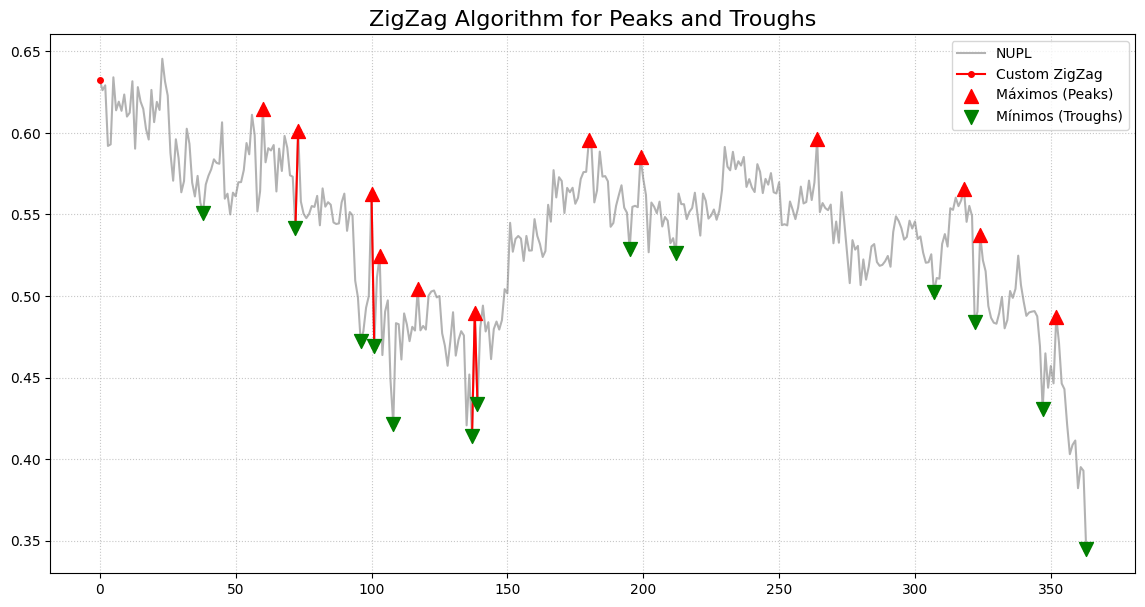

In [118]:
prop_threshold = 0.1
zigzag, zigzag_clean, max_zig, min_zag = zigzag_algorithm(df_z['net_unrealized_profit_loss'], prop=prop_threshold)
PlotZigZag(df_z, zigzag, max_zig, min_zag)